In [19]:
import pickle
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

# Data Processing 

In [20]:
sales_data = pd.read_csv('Data/sales dataset.csv')
sales_data['salesDate'] = pd.to_datetime(sales_data['salesDate'], infer_datetime_format=True)
selected_columns1 =['salesAmount', 'salesDate']
sales_data = sales_data[selected_columns1]
##########################################################################
expenses_data = pd.read_csv('Data/expenses dataset.csv')
expenses_data['expenseDate'] = pd.to_datetime(expenses_data['expenseDate'], infer_datetime_format=True)
selected_columns =['expenseAmount', 'expenseDate']
expenses_data = expenses_data[selected_columns]
##########################################################################
# print('Shape of expenses data', expenses_data.shape)
# print('Shape of sales data', sales_data.shape)
# sales_data

In [21]:
# The function groups either the expense or sales data into the monthly series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupMonth(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Amount'] = df.iloc[:,0]
    monthly = df.groupby(['Year','Month'])['Amount'].sum().reset_index()
    return monthly

# The function groups either the expense or sales data into the daily series
# But the first column must be the amount and the second column must be the dates in datetime format
def groupDay(df):
    df['Year'] = df.iloc[:,1].dt.year
    df['Month'] = df.iloc[:,1].dt.month
    df['Day'] = df.iloc[:,1].dt.day
    df['Amount'] = df.iloc[:,0]
    daily = df.groupby(['Year','Month','Day'])['Amount'].sum().reset_index()
    return daily

def monthlyToSingleDate(df, Year, Month):
    df['date'] = pd.to_datetime(df['Year'].astype(str) + '-' + df['Month'].astype(str))
    df = df.drop(['Year','Month',], axis=1)
    df = df.set_index('date')
    return df

def dailyToSingleDate(df,Year, Month, Day):
        df['date'] = pd.to_datetime(df[['Year','Month','Day']])
        df = df.drop(['Year','Month','Day'], axis=1)
        df = df.set_index('date')
        return df

In [22]:
sd = groupDay(sales_data)
ed = groupDay(expenses_data)
em = groupMonth(expenses_data)
sm = groupMonth(sales_data)

daily_sales = dailyToSingleDate(sd, sd['Year'], sd['Month'], sd['Day'])
daily_expenses = dailyToSingleDate(ed, ed['Year'], ed['Month'], ed['Day'])
monthly_expenses = monthlyToSingleDate(em, em['Year'], em['Month'])
monthly_sales = monthlyToSingleDate(sm, sm['Year'], sm['Month'])

In [23]:
dailySales = daily_sales[705:]    #705 for the removal of irrelevant data points
dailyExpenses = daily_expenses[890:]  #890 for the removal of irrelevant data points
monthlySales = monthly_sales
monthlyExpenses = monthly_expenses

In [24]:
print(len(monthlyExpenses), len(monthlySales))
print(len(dailyExpenses), len(dailySales))

43 38
182 236


In [25]:
category1 = dailySales
category2 = dailyExpenses
category3 = monthlySales
category4 = monthlyExpenses
category = category2

# Remove Outliers

In [26]:
def remove_outliers_zscore(data, threshold=4):
    z_scores = np.abs((data - np.mean(data)) / np.std(data))
    filtered_data = data[(z_scores < threshold)]
    return filtered_data

filteredCategory = remove_outliers_zscore(category)
category = filteredCategory
category = category.tail(30)

C:\Users\Berlin\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [27]:
category.reset_index(inplace=True)
category = pd.DataFrame(category['Amount'])
Category = category

# Adding Lagged Variables

In [28]:
lags = [1,2,3,4]
for lag in lags:
    category[f'lag{lag}'] = category['Amount'].shift(lag)
category.dropna(inplace=True)
selected_columns = ['Amount', 'lag1', 'lag2', 'lag3','lag4']
category = category[selected_columns]

# Standardization

In [29]:
scaler = StandardScaler()
X = scaler.fit_transform(category.drop(category.columns[0], axis=1))
Y = scaler.fit_transform(np.array(category.iloc[:,0]).reshape(-1, 1))

# Train - Test Split

In [30]:
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.2, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, shuffle=True)

# Reshape for LSTM input

In [31]:
X_train_scaled_reshaped = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_scaled_reshaped = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
X_val_scaled_reshaped = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

# Fit the model

In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [33]:
# model = Sequential([
#     LSTM(550, return_sequences=True, activation='tanh'),
#     Dropout(0.2),
#     LSTM(128, activation='tanh'),
#     Dropout(0.2),
#     Dense(64, activation = 'relu'),
#     Dense(32, activation = 'relu'),
#     Dense(2)
# ])

model = Sequential()
model.add(LSTM(units=550, return_sequences=True,activation='tanh', input_shape=(X_train_scaled_reshaped.shape[1], X_train_scaled_reshaped.shape[2])))
model.add(LSTM(units=250, activation='tanh'))
model.add(Dense(units=50, activation='relu'))
model.add(Dense(units=1))

In [34]:
cp = ModelCheckpoint('Models Pickled Flies/Expenses Day Prediction Model(Standardization)/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics = [RootMeanSquaredError()])

In [36]:
model.fit(X_train_scaled_reshaped, y_train, validation_data=(X_val_scaled_reshaped, y_val),epochs=100, batch_size=32,callbacks=[cp])

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 1.0820 - root_mean_squared_error: 1.0402INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Standardization)\assets


INFO:tensorflow:Assets written to: Models Pickled Flies/Expenses Day Prediction Model(Standardization)\assets


1/1 [==============================] - 43s 43s/step - loss: 1.0820 - root_mean_squared_error: 1.0402 - val_loss: 0.5844 - val_root_mean_squared_error: 0.7644
Epoch 2/100
1/1 [==============================] - 0s 204ms/step - loss: 1.0803 - root_mean_squared_error: 1.0394 - val_loss: 0.5848 - val_root_mean_squared_error: 0.7648
Epoch 3/100
1/1 [==============================] - 0s 249ms/step - loss: 1.0788 - root_mean_squared_error: 1.0387 - val_loss: 0.5854 - val_root_mean_squared_error: 0.7651
Epoch 4/100
1/1 [==============================] - 0s 185ms/step - loss: 1.0775 - root_mean_squared_error: 1.0380 - val_loss: 0.5861 - val_root_mean_squared_error: 0.7656
Epoch 5/100
1/1 [==============================] - 0s 185ms/step - loss: 1.0762 - root_mean_squared_error: 1.0374 - val_loss: 0.5870 - val_root_mean_squared_error: 0.7662
Epoch 6/100
1/1 [==============================] - 0s 199ms/step - loss: 1.0750 - root_mean_squared_error: 1.0368 - val_loss: 0.5879 - val_root_mean_squared_e

Epoch 49/100
1/1 [==============================] - 0s 167ms/step - loss: 1.0197 - root_mean_squared_error: 1.0098 - val_loss: 0.6317 - val_root_mean_squared_error: 0.7948
Epoch 50/100
1/1 [==============================] - 0s 167ms/step - loss: 1.0180 - root_mean_squared_error: 1.0090 - val_loss: 0.6328 - val_root_mean_squared_error: 0.7955
Epoch 51/100
1/1 [==============================] - 0s 167ms/step - loss: 1.0164 - root_mean_squared_error: 1.0082 - val_loss: 0.6340 - val_root_mean_squared_error: 0.7962
Epoch 52/100
1/1 [==============================] - 0s 167ms/step - loss: 1.0147 - root_mean_squared_error: 1.0073 - val_loss: 0.6352 - val_root_mean_squared_error: 0.7970
Epoch 53/100
1/1 [==============================] - 0s 173ms/step - loss: 1.0130 - root_mean_squared_error: 1.0065 - val_loss: 0.6363 - val_root_mean_squared_error: 0.7977
Epoch 54/100
1/1 [==============================] - 0s 155ms/step - loss: 1.0113 - root_mean_squared_error: 1.0056 - val_loss: 0.6375 - val_

Epoch 97/100
1/1 [==============================] - 0s 282ms/step - loss: 0.9178 - root_mean_squared_error: 0.9580 - val_loss: 0.7136 - val_root_mean_squared_error: 0.8448
Epoch 98/100
1/1 [==============================] - 0s 211ms/step - loss: 0.9151 - root_mean_squared_error: 0.9566 - val_loss: 0.7163 - val_root_mean_squared_error: 0.8464
Epoch 99/100
1/1 [==============================] - 0s 264ms/step - loss: 0.9125 - root_mean_squared_error: 0.9552 - val_loss: 0.7191 - val_root_mean_squared_error: 0.8480
Epoch 100/100
1/1 [==============================] - 0s 210ms/step - loss: 0.9098 - root_mean_squared_error: 0.9538 - val_loss: 0.7219 - val_root_mean_squared_error: 0.8496


# Evaluate Model

In [37]:
from tensorflow.keras.models import load_model
pickledModel = load_model('Models Pickled Flies/Expenses Day Prediction Model(Standardization)/')

In [38]:
mse = model.evaluate(X_test_scaled_reshaped, y_test, verbose=0)
print(f'Mean Squared Error is {mse}')

Mean Squared Error is [1.01949143409729, 1.0096986293792725]


In [40]:
train_predictions = model.predict(X_train_scaled_reshaped)
predictions = scaler.inverse_transform(train_predictions).flatten()
train_target = scaler.inverse_transform(y_train).flatten()
train_results = pd.DataFrame(data={'Train Predictions': predictions, 'Actuals':train_target})
train_results

1/1 [==============================] - 3s 3s/step


,Train Predictions,Actuals
0,118753.601562,182150.0
1,117494.320312,59100.0
2,85759.226562,108100.0
3,117731.570312,88900.0
4,107215.898438,115500.0
5,111963.492188,90500.0
6,107265.546875,351180.0
7,134654.093750,237900.0
8,67669.148438,63250.0
9,91682.679688,37000.0


In [46]:
index_start = 4
index = range(index_start, index_start + len(predictions))
df = pd.DataFrame(predictions, index=index, columns=['Values'])

<function matplotlib.pyplot.xlabel(xlabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

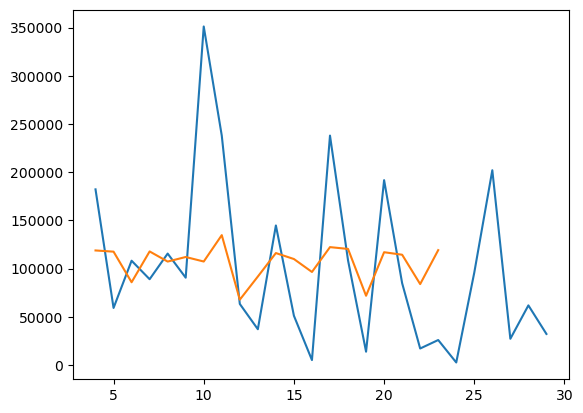

In [48]:
plt.plot(Category['Amount'], label='Original Data')
plt.plot(df)
plt.xlabel

# Make Time Series Predictions

In [20]:
predictions = model.predict(X_test)

array([130889.15, 141946.75,  93238.8 ,  81961.55, 106345.55,  86750.  ])